In [2]:
import pandas as pd
import numpy as np

def analyze_and_save_windows(prices, ticker="SIM", save_files=True):
    # 1. Setup
    HORIZONS = 5 * (np.arange(26) + 1)
    ret = np.diff(np.log(prices))
    scale = np.sqrt(252)
    
    all_dfs = []

    # 2. Vectorized Window Processing
    for T in HORIZONS:
        # Calculate how many full windows of size T fit in the data
        n_windows = len(ret) // T
        if n_windows == 0:
            continue
            
        # Truncate and reshape to (n_windows, T)
        # This effectively "slices" all windows at once
        windows = ret[:n_windows * T].reshape(n_windows, T)
        
        # Vectorized calculations across axis 1 (the window)
        sums = windows.sum(axis=1)
        sigmas = windows.std(axis=1, ddof=0) * scale
        z_raws = sums / np.sqrt(T / 252.0)
        
        # Create a temporary dataframe for this Horizon T
        # (Appending to a list of DFs is faster than appending dictionaries to a list)
        horizon_df = pd.DataFrame({
            "ticker": ticker,
            "date": (np.arange(1, n_windows + 1) * T),
            "T": T,
            "z_raw": z_raws,
            "sigma": sigmas
        })
        all_dfs.append(horizon_df)

    if not all_dfs:
        return None

    df = pd.concat(all_dfs, ignore_index=True)

    # 3. Filtering and De-meaning
    # Filter for finite and positive sigma in one go
    mask = np.isfinite(df['z_raw']) & np.isfinite(df['sigma']) & (df['sigma'] > 0)
    df = df[mask].copy()
    
    # Vectorized global de-meaning
    df["z"] = df["z_raw"] - df.groupby(["ticker", "T"])["z_raw"].transform("mean")
    df = df.drop(columns="z_raw").reset_index(drop=True)

    # 4. Exporting (Logic remains the same but slightly more efficient)
    if save_files:
        n = len(df) // 3
        if n > 0:
            df.iloc[:n].to_parquet("dataset_part1.parquet")
            df.iloc[n:2*n].to_parquet("dataset_part2.parquet")
            df.iloc[2*n:].to_parquet("dataset_part3.parquet")
            print(f"Saved {len(df)} windows for ticker: {ticker}")

        if len(prices) == 100000:
            pd.DataFrame({"Day": np.arange(1, len(prices) + 1), "Price": prices}).to_csv("simulated_prices.csv", index=False)
            print("Saved 100k prices to simulated_prices.csv")

    return df

In [1]:
import numpy as np

def simulate_garch_raw(beta, mu_annual, sigma_annual, num_samples=400, N=2500, S0=100, seed=42):
    """
    Simulates GARCH(1,1) process using standard nomenclature (alpha, beta).
    Persistence (alpha + beta) is fixed at 0.99, meaning gamma = 0.01.
    
    Returns:
        tuple: (all_prices, all_vols)
    """
    trading_days = 252
    alpha = 0.99 - beta  # Derived from your alpha + beta < 1 logic
    gamma = 1 - alpha - beta # Fixed at 0.01
    
    # Calculate omega based on the target long-run annual volatility
    target_V_daily = (sigma_annual**2) / trading_days
    omega = target_V_daily * gamma
    
    all_prices = []
    all_vols = []
    
    # Set seed for reproducibility
    np.random.seed(seed)
    
    for s in range(num_samples):
        # Reset for each sample block
        sample_prices = [S0]
        sample_vols = []
        V = target_V_daily 

        for i in range(1, N):
            current_sigma_daily = np.sqrt(V)
            # Store annualized volatility for tracking
            sample_vols.append(current_sigma_daily * np.sqrt(trading_days))

            # Price Update (Geometric Brownian Motion step)
            Z = np.random.normal(0, 1)
            log_return = (mu_annual / trading_days) - 0.5 * V + current_sigma_daily * Z
            
            new_price = sample_prices[-1] * np.exp(log_return)
            if new_price < 0.01:
                new_price = 0.01 
            sample_prices.append(new_price)
            
            # Variance Update (Standard GARCH 1,1 Nomenclature)
            # V_t = omega + alpha * epsilon_{t-1}^2 + beta * V_{t-1}
            ret_sq = ((sample_prices[-1] - sample_prices[-2]) / sample_prices[-2])**2
            V = omega + (alpha * ret_sq) + (beta * V)

        # Align lengths: the last price doesn't have a subsequent volatility calculated
        sample_vols.append(sample_vols[-1])
        
        # Stitch into global lists
        all_prices.extend(sample_prices)
        all_vols.extend(sample_vols)
        
    return all_prices, all_vols

# --- Usage Example ---
# beta = 0.81 (replaces lam)
# alpha = 0.99 - 0.81 = 0.18
# prices, vols = simulate_garch_raw(beta=0.81, mu_annual=0.0967, sigma_annual=0.0956)

In [3]:
import numpy as np

def simulate_garch_vectorized(beta, mu_annual, sigma_annual, num_samples=400, N=2500, S0=100, seed=42):
    """
    High-performance CPU version using NumPy vectorization and standard GARCH nomenclature.
    Persistence (alpha + beta) is fixed at 0.99.
    """
    trading_days = 252
    mu_daily = mu_annual / trading_days
    
    # Standard GARCH parameters
    alpha = 0.99 - beta           # Derived from persistence of 0.99
    gamma = 1 - (alpha + beta)    # Should be exactly 0.01
    
    # Correct Omega calculation using Variance Targeting
    target_V_daily = (sigma_annual**2) / trading_days
    omega = target_V_daily * gamma
    
    # Initialize arrays for all samples
    prices = np.zeros((num_samples, N))
    vols = np.zeros((num_samples, N))
    
    # Start variance at the long-run target
    V = np.full(num_samples, target_V_daily)
    prices[:, 0] = S0
    
    rng = np.random.default_rng(seed)
    # Pre-generate all random numbers for speed
    Z = rng.standard_normal((num_samples, N))

    for i in range(1, N):
        curr_vol = np.sqrt(V)
        # Store annualized volatility for the current step
        vols[:, i-1] = curr_vol * np.sqrt(trading_days)
        
        # Vectorized price update across all samples
        log_return = mu_daily - 0.5 * V + curr_vol * Z[:, i]
        prices[:, i] = prices[:, i-1] * np.exp(log_return)
        
        # Apply price floor
        prices[:, i] = np.maximum(prices[:, i], 0.01)
        
        # Vectorized GARCH variance update
        # Standard form: V_t = omega + alpha * epsilon^2 + beta * V_{t-1}
        ret_sq = ((prices[:, i] - prices[:, i-1]) / prices[:, i-1])**2
        V = omega + (alpha * ret_sq) + (beta * V)

    # Final volatility alignment
    vols[:, -1] = vols[:, -2]
    
    # Return flattened lists to match original function signature
    return prices.flatten().tolist(), vols.flatten().tolist()

# --- Usage ---
# prices, vols = simulate_garch_vectorized(beta=0.81, mu_annual=0.0967, sigma_annual=0.0956)

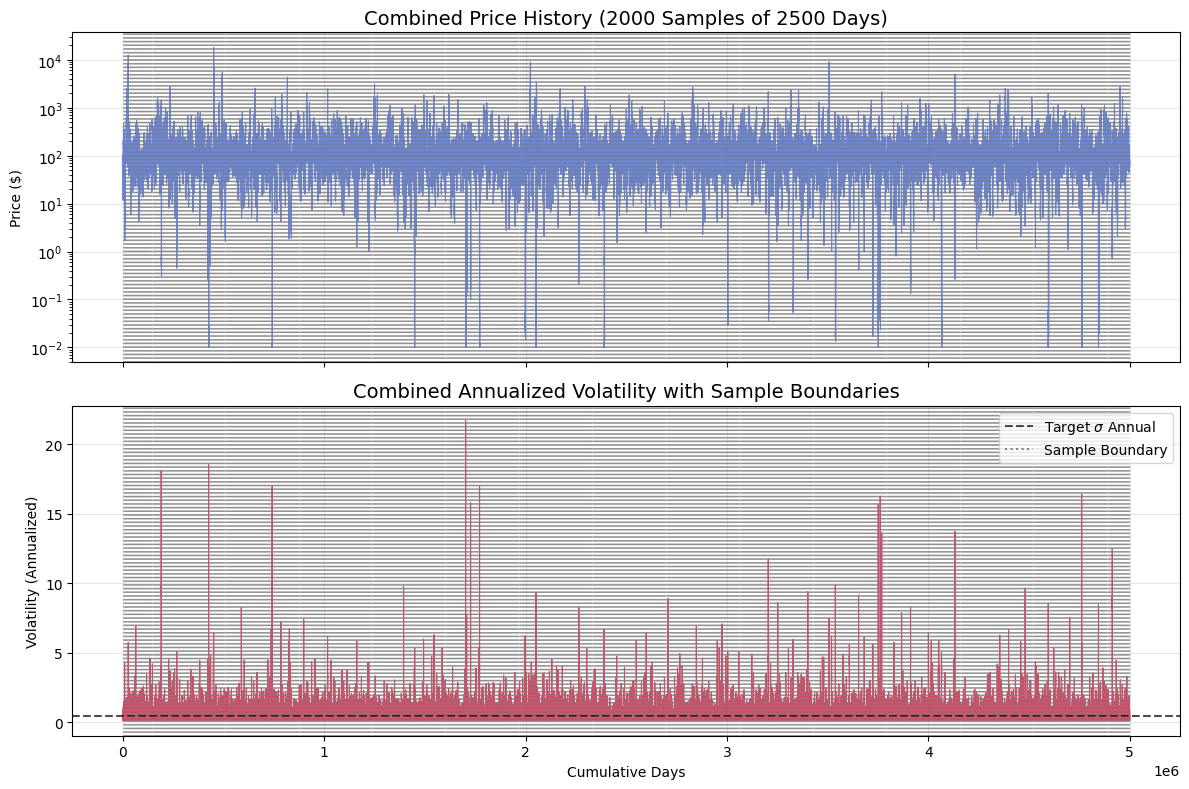

Saved 3854404 windows for ticker: SIM


,ticker,date,T,sigma,z
0,SIM,5,5,0.493508,-0.530303
1,SIM,10,5,0.221346,-0.044867
2,SIM,15,5,0.221478,0.253240
3,SIM,20,5,0.169632,0.015910
4,SIM,25,5,0.146364,-0.032676
...,...,...,...,...,...
3854399,SIM,4999410,130,0.231637,-0.035705
3854400,SIM,4999540,130,0.178489,-0.069430
3854401,SIM,4999670,130,0.236426,-0.147853
3854402,SIM,4999800,130,0.161582,0.092770


In [30]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Global Configuration ---
N = 2500             # Days per sample (approx 10 years)
num_samples = 2000     # Number of independent simulations

# --- 2. Model Parameters ---
sigma_annual = 0.425  
mu_annual = 0.06        
beta = 0.8  # Changed from lam to beta to match the new function signature

# --- 3. Run Simulation ---
# Calling the updated vectorized function with beta
all_prices, all_vols = simulate_garch_vectorized(
    beta=beta, 
    mu_annual=mu_annual, 
    sigma_annual=sigma_annual, 
    num_samples=num_samples,
    N=N
)

# --- 4. Visualization ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top Plot: Price History (Log scale helpful for long series)
ax1.plot(all_prices, color='royalblue', linewidth=0.8, alpha=0.8)
ax1.set_title(f"Combined Price History ({num_samples} Samples of {N} Days)", fontsize=14)
ax1.set_ylabel("Price ($)")
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Bottom Plot: Volatility History
ax2.plot(all_vols, color='crimson', linewidth=0.8, alpha=0.8)
# Visualizing mean reversion to the target sigma
ax2.axhline(y=sigma_annual, color='black', linestyle='--', alpha=0.7, label=r'Target $\sigma$ Annual')
ax2.set_title(r"Combined Annualized Volatility with Sample Boundaries", fontsize=14)
ax2.set_ylabel("Volatility (Annualized)")
ax2.set_xlabel("Cumulative Days")
ax2.grid(True, alpha=0.3)

# --- ADD VERTICAL BOUNDARY LINES ---
# These help visualize where one simulation ends and the next begins
for s in range(1, num_samples):
    boundary_day = s * N
    ax1.axvline(x=boundary_day, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    ax2.axvline(x=boundary_day, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# Add a single label for the boundary lines to the legend
ax2.plot([], [], color='gray', linestyle=':', label='Sample Boundary')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# --- 5. Window Analysis ---
# analyze_and_save_windows is assumed to be defined elsewhere in your script
display(analyze_and_save_windows(all_prices))

In [13]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm  # Step 1: Import tqdm

def qvar(z, s0, zoff):
    return (s0**2 + (z - zoff)**2 / 2)

# --- 1. Optimization Settings ---
beta_range = np.linspace(0.6, 0.9, 5)     # Changed lam to beta
mu_range = np.linspace(0.06, 0.1, 5)
sigma_range = np.linspace(0.1, 0.2, 5)

best_r2 = -np.inf
best_params = None

# Calculate total iterations for the progress bar
total_iterations = len(beta_range) * len(mu_range) * len(sigma_range)

print(f"Starting 3D Grid Search...")
print("-" * 60)

# Step 2: Wrap the outer loop with tqdm
with tqdm(total=total_iterations, desc="Optimizing GARCH") as pbar:
    for b in beta_range:
        for m in mu_range:
            for s_ann in sigma_range:
                # --- 2. Simulation Logic ---
                # Using the updated function name and parameters
                all_prices, _ = simulate_garch_vectorized(beta=b, mu_annual=m, sigma_annual=s_ann, num_samples=2000, N=2500)

                # --- 3. Process Windows ---
                df_temp = analyze_and_save_windows(all_prices, save_files=False)

                if df_temp is not None and not df_temp.empty:
                    df_temp["var"] = df_temp.sigma**2

                    zmax = 0.6
                    delz = 0.05
                    nbins = int(2*zmax/delz + 1)
                    bins = np.linspace(-zmax, zmax, nbins)

                    binned = (df_temp.assign(z_bin=pd.cut(df_temp.z, bins=bins, include_lowest=True))
                        .groupby('z_bin', observed=False)
                        .agg(z_mid=('z', 'mean'), var=('var', 'mean'))
                        .dropna())

                    # --- 4. Curve Fitting & R2 ---
                    try:
                        if len(binned) >= 5:
                            popt = [0.2586, 0.0214] 
                            fitted = qvar(binned.z_mid, popt[0], popt[1])
                            
                            ss_res = np.sum((binned["var"] - fitted)**2)
                            ss_tot = np.sum((binned["var"] - binned["var"].mean())**2)
                            r2 = 1 - (ss_res / ss_tot)
                            
                            if r2 > best_r2:
                                best_r2 = r2
                                best_params = {
                                    'beta': b, 'mu': m, 'sigma': s_ann, 
                                    'popt': popt, 'r2': r2
                                }
                                # Step 3: Optional - Update the bar description with the current best score
                                pbar.set_postfix({"Best R2": f"{r2:.3f}"})
                                
                    except Exception:
                        continue
                
                # Step 4: Advance the progress bar after each combination
                pbar.update(1)

# --- 5. Results Summary ---
print("-" * 60)
if best_params:
    print("OPTIMIZATION COMPLETE")
    print(f"Winner Beta:  {best_params['beta']:.4f}")
    print(f"Winner Mu:    {best_params['mu']:.4f}")
    print(f"Winner Sigma: {best_params['sigma']:.4f}")
    print(f"Max R2:       {best_params['r2']:.3f}")

Starting 3D Grid Search...
------------------------------------------------------------


Optimizing GARCH:   0%|          | 0/125 [00:00<?, ?it/s]

Optimizing GARCH: 100%|██████████| 125/125 [04:44<00:00,  2.27s/it, Best R2=0.733]

------------------------------------------------------------
OPTIMIZATION COMPLETE
Winner Beta:  0.6000
Winner Mu:    0.0600
Winner Sigma: 0.2000
Max R2:       0.733


In [26]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm
from joblib import Parallel, delayed
import itertools

# --- 1. Core Functions ---
def qvar(z, s0, zoff):
    return (s0**2 + (z - zoff)**2 / 2)

def evaluate_params(b, m, s_ann):
    """ Worker function to evaluate a single parameter combination """
    try:
        # 1. Simulate
        # Note: Ensure simulate_garch_vectorized is defined in your environment
        all_prices, _ = simulate_garch_vectorized(
            beta=b, 
            mu_annual=m, 
            sigma_annual=s_ann, 
            num_samples=1000, # Reduced slightly for faster grid search
            N=2500
        )
        
        # 2. Process Windows
        # Note: Ensure analyze_and_save_windows is defined in your environment
        df_temp = analyze_and_save_windows(all_prices, save_files=False)
        
        if df_temp is None or df_temp.empty:
            return None

        df_temp["var"] = df_temp.sigma**2

        # 3. Binning Logic
        zmax = 0.6
        delz = 0.05
        bins = np.linspace(-zmax, zmax, int(2*zmax/delz + 1))

        binned = (df_temp.assign(z_bin=pd.cut(df_temp.z, bins=bins, include_lowest=True))
            .groupby('z_bin', observed=False)
            .agg(z_mid=('z', 'mean'), var=('var', 'mean'))
            .dropna())

        if len(binned) < 5:
            return None

        # 4. R2 Calculation against target parabola
        target_popt = [0.2586, 0.0214] 
        fitted = qvar(binned.z_mid, target_popt[0], target_popt[1])
        
        ss_res = np.sum((binned["var"] - fitted)**2)
        ss_tot = np.sum((binned["var"] - binned["var"].mean())**2)
        r2 = 1 - (ss_res / ss_tot)
        
        return {'beta': b, 'mu': m, 'sigma': s_ann, 'r2': r2}
    
    except Exception:
        return None

# --- 2. Define Ranges and Grid ---
beta_range = np.linspace(0.7, 0.9, 5)     # Changed lam to beta
mu_range = np.linspace(0.06, 0.8, 5)
sigma_range = np.linspace(0.4, 0.45, 5)

# Create all combinations (The Grid)
param_grid = list(itertools.product(beta_range, mu_range, sigma_range))

# --- 3. Parallel Execution ---
print(f"Starting Parallel Optimization ({len(param_grid)} combinations)...")

# n_jobs=-1 uses all available CPU cores
results = Parallel(n_jobs=-1)(
    delayed(evaluate_params)(b, m, s) for b, m, s in tqdm(param_grid, desc="Grid Searching")
)

# --- 4. Process Results ---
valid_results = [r for r in results if r is not None]

print("-" * 60)
if valid_results:
    best_params = max(valid_results, key=lambda x: x['r2'])
    print("OPTIMIZATION COMPLETE")
    print(f"Winner Beta (Persistence): {best_params['beta']:.4f}")
    print(f"Winner Alpha (Shock):      {0.99 - best_params['beta']:.4f}")
    print(f"Winner Mu:                 {best_params['mu']:.4f}")
    print(f"Winner Sigma:              {best_params['sigma']:.4f}")
    print(f"Max R2 score:              {best_params['r2']:.4f}")
else:
    print("No valid results found. Check simulation settings.")

Starting Parallel Optimization (125 combinations)...


Grid Searching: 100%|██████████| 125/125 [00:56<00:00,  2.22it/s]


------------------------------------------------------------
OPTIMIZATION COMPLETE
Winner Beta (Persistence): 0.8000
Winner Alpha (Shock):      0.1900
Winner Mu:                 0.0600
Winner Sigma:              0.4250
Max R2 score:              0.9974


Starting Convergence Test...
Fixed Params: Beta=0.8, Mu=0.06, Sig=0.425
Testing 20 different sample sizes...
------------------------------------------------------------
Samples:   40 | Total Days:   100,000 | R²: 0.9662
Samples:  143 | Total Days:   357,500 | R²: 0.9853
Samples:  246 | Total Days:   615,000 | R²: 0.9883
Samples:  349 | Total Days:   872,500 | R²: 0.9899
Samples:  452 | Total Days: 1,130,000 | R²: 0.9942
Samples:  555 | Total Days: 1,387,500 | R²: 0.9971
Samples:  658 | Total Days: 1,645,000 | R²: 0.9970
Samples:  762 | Total Days: 1,905,000 | R²: 0.9963
Samples:  865 | Total Days: 2,162,500 | R²: 0.9967
Samples:  968 | Total Days: 2,420,000 | R²: 0.9973
Samples: 1071 | Total Days: 2,677,500 | R²: 0.9974
Samples: 1174 | Total Days: 2,935,000 | R²: 0.9977
Samples: 1277 | Total Days: 3,192,500 | R²: 0.9976
Samples: 1381 | Total Days: 3,452,500 | R²: 0.9970
Samples: 1484 | Total Days: 3,710,000 | R²: 0.9975
Samples: 1587 | Total Days: 3,967,500 | R²: 0.9972
Samples: 1690 

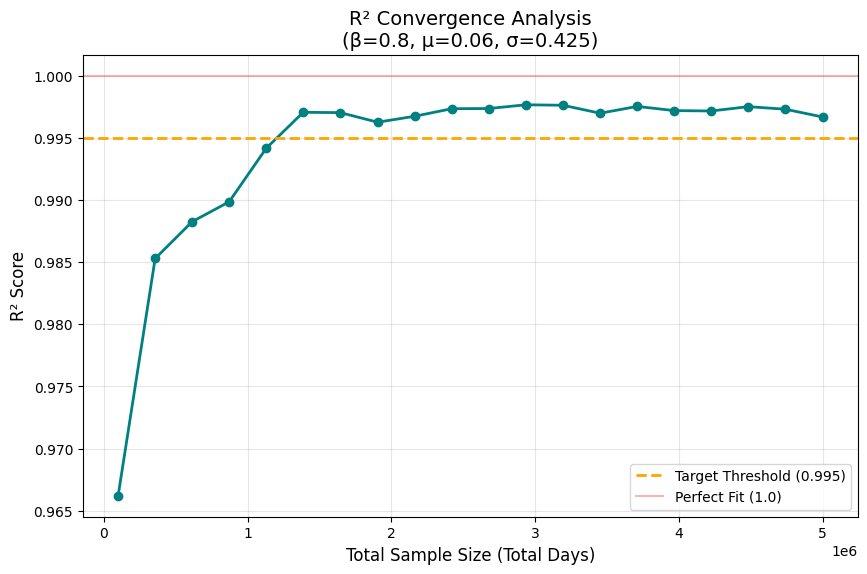

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Fixed Parameters ---
sigma_fixed = 0.425
mu_fixed = 0.06
beta_fixed = 0.8        # Standard GARCH nomenclature (formerly lam)
N_per_sample = 2500

# Range of num_samples to test (from 40 up to 2000)
sample_sizes = np.linspace(40, 2000, 20).astype(int) 

results = []

print(f"Starting Convergence Test...")
print(f"Fixed Params: Beta={beta_fixed}, Mu={mu_fixed}, Sig={sigma_fixed}")
print(f"Testing {len(sample_sizes)} different sample sizes...")
print("-" * 60)

for num_s in sample_sizes:
    # 2. Simulation
    # Using the updated vectorized function with beta and omega fix
    all_prices, _ = simulate_garch_vectorized(
        beta=beta_fixed, 
        mu_annual=mu_fixed, 
        sigma_annual=sigma_fixed, 
        num_samples=num_s, 
        N=N_per_sample,
        seed=42  # Seeded for consistent convergence comparisons
    )

    # 3. Process Windows
    df_temp = analyze_and_save_windows(all_prices, save_files=False)

    if df_temp is not None and not df_temp.empty:
        df_temp["var"] = df_temp.sigma**2

        # Banning/Binning logic
        zmax, delz = 0.6, 0.05
        bins = np.linspace(-zmax, zmax, int(2*zmax/delz + 1))
        
        binned = (df_temp.assign(z_bin=pd.cut(df_temp.z, bins=bins, include_lowest=True))
                    .groupby('z_bin', observed=False)
                    .agg(z_mid=('z', 'mean'), var=('var', 'mean'))
                    .dropna())

        # 4. Calculate R2 against the target parabola
        if len(binned) > 5:
            popt = [0.2586, 0.0214] # Target coefficients
            fitted = qvar(binned.z_mid, popt[0], popt[1])
            
            ss_res = np.sum((binned["var"] - fitted)**2)
            ss_tot = np.sum((binned["var"] - binned["var"].mean())**2)
            r2 = 1 - (ss_res / ss_tot)
            
            total_days = num_s * N_per_sample
            results.append({'total_days': total_days, 'r2': r2})
            
            # Print result for each number instead of using a progress bar
            print(f"Samples: {num_s:4} | Total Days: {total_days:9,} | R²: {r2:.4f}")

# --- 5. Visualization ---
res_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(res_df['total_days'], res_df['r2'], marker='o', linestyle='-', color='teal', linewidth=2)

# Add the 0.995 threshold line
plt.axhline(y=0.995, color='orange', linestyle='--', linewidth=2, 
            label='Target Threshold (0.995)')

# Add the Perfect Fit line
plt.axhline(y=1.0, color='red', linestyle='-', alpha=0.3, label='Perfect Fit (1.0)')

# Formatting
plt.title(f'R² Convergence Analysis\n(β={beta_fixed}, μ={mu_fixed}, σ={sigma_fixed})', fontsize=14)
plt.xlabel('Total Sample Size (Total Days)', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig("convergence_analysis.png", dpi=300)
plt.show()